# Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pandas as pd
import seaborn as sns
from tqdm import tqdm
from IPython.display import Image, SVG

sns.set_theme()

# Data Loading

In [3]:

def load_all_experiments(experiment_folder="./experiments"):
    """
    Given a folder with a number of experiments, where each experiment has one pickled dataframe, load and return all
    dataframes.

    """
    # TODO: Read from configs, too, and insert these values as metadata.
    experiment_folder = Path(experiment_folder)
    if not experiment_folder.is_dir():
        raise ValueError(f"Not a valid folder: {experiment_folder}")

    all_frames = {}
    for d in tqdm(Path(experiment_folder).iterdir(), "Scanning all experiments"):
        if d.is_dir():
            gen_pkl = d / "generations.pkl"
            if gen_pkl.is_file():
                df = pd.read_pickle(gen_pkl)
                df["experiment"] = d.name
                prev_index = df.index.names
                df.reset_index(inplace=True)
                df.set_index(["experiment"] + prev_index, inplace=True)
                all_frames[d.name] = df
    return all_frames


In [225]:
experiment_map = load_all_experiments()
print(f"Found {len(experiment_map)} experiments.")

Scanning all experiments: 155it [00:01, 106.33it/s]


Found 117 experiments.


# Collate All Experiments Together

In [288]:
experiments = pd.concat(experiment_map.values())

In [289]:
# Add a "Trial" column by parsing the experiment name.
# expcol = experiments.index.get_level_values("experiment")
experiments.reset_index(inplace=True)
trialcol = experiments["experiment"].str.extract("(.+?)(-([0-9]))?$")[2].apply(
    lambda x: 0 if (x is None or x is np.nan) else int(x))
experiments.insert(1, "trial", trialcol)
experiments.set_index(["experiment", "trial", "generation"], inplace=True)

In [290]:
experiments

num_species  \
experiment                                 trial generation                
walker-grow150-prune50                     0     1                     5   
                                                 2                     5   
                                                 3                     5   
                                                 4                     5   
                                                 5                     5   
...                                                                  ...   
walker-init0.1-high-struct-mutation-c90n30 0     196                   5   
                                                 197                   5   
                                                 198                   5   
                                                 199                   5   
                                                 200                   5   

                                                             best_genome  \
experiment                                 trial generation                
walker-grow150-prune50                     0     1                    10   
                                                 2                   159   
                                                 3                   374   
                                                 4                   374   
                                                 5                   667   
...                                                                  ...   
walker-init0.1-high-struct-mutation-c90n30 0     196               24024   
                                                 197               24024   
                                                 198               24024   
                                                 199               24024   
                                                 200               24024   

                                                             conn_add_prob  \
experiment                                 trial generation                  
walker-grow150-prune50                     0     1                     0.9   
                                                 2                     0.9   
                                                 3                     0.9   
                                                 4                     0.9   
                                                 5                     0.9   
...                                                                    ...   
walker-init0.1-high-struct-mutation-c90n30 0     196                   0.1   
                                                 197                   0.1   
                                                 198                   0.1   
                                                 199                   0.1   
                                                 200                   0.1   

                                                             conn_delete_prob  \
experiment                                 trial generation                     
walker-grow150-prune50                     0     1                        0.1   
                                                 2                        0.1   
                                                 3                        0.1   
                                                 4                        0.1   
                                                 5                        0.1   
...                                                                       ...   
walker-init0.1-high-struct-mutation-c90n30 0     196                      0.1   
                                                 197                      0.1   
                                                 198                      0.1   
                                                 199                      0.1   
                                                 200                      0.1   

              

# Plotting Functions

In [312]:
import warnings


def get_stat_name(var):
    names = var.split(".")
    return names[1] if len(names) > 1 else "value"


def get_variable_name(var):
    return var.split(".")[0]


def plot_runs(df, vars_to_plot, **kwargs):
    df = df.melt(value_vars=vars_to_plot, ignore_index=False)
    df["stat"] = df["variable"].apply(get_stat_name)
    df["variable"] = df["variable"].apply(get_variable_name)
    df = df[~df.value.isnull()]

    # Temporarily suppress this annoying and unnecessary warning coming from Seaborn.
    with warnings.catch_warnings():
        warnings.filterwarnings("ignore", message=".*not compatible with tight_layout.*")
        fg = sns.relplot(
            data=df,
            x="generation",
            y="value",
            row="variable",
            hue="stat",
            # palette="tab10",
            kind="line",
            height=3,
            aspect=3,
            facet_kws=dict(sharey=False, gridspec_kws=dict(top=0.92)),
            **kwargs
        )
    # Adjust labels.
    fg.set_axis_labels("Generation", "Value")
    plt.show()
    return fg


def plot_experiment(df, expname, vars_to_plot):
    expcol = df.index.get_level_values("experiment")
    df = df.loc[expcol == expname, :]
    fg = plot_runs(df, vars_to_plot, errorbar="sd")
    fg.figure.suptitle(f"Experiment: {expname}")
    return fg


def plot_trials(df, expname, vars_to_plot, summarize=True):
    expcol = df.index.get_level_values("experiment")
    df = df.loc[expcol.str.fullmatch(expname + "(-[0-9])?$")]
    kwargs = {}
    if summarize:
        kwargs["errorbar"] = "sd"
    else:
        kwargs["estimator"] = None
        kwargs["units"] = "trial"
    fg = plot_runs(df, vars_to_plot, **kwargs)
    fg.figure.suptitle(f"Experiment: {expname}")
    return fg


# Analysis

In [227]:
best_performers = experiments.groupby("experiment").max("fitness.max")["fitness.max"].sort_values(ascending=False)
best_performers
# TODO: Get last value from each group.

experiment
walker-init0.1-high-struct-mutation-single    305.080747
walker-init0.1-grow-always-c90n30             303.538692
walker-high-struct-mutation-c90n30-1          303.084540
walker-init0.1-grow-only-pop300               290.510345
walker-grow-prune-spec2.5                     287.301691
                                                 ...    
walker-init0.1-grow50-prune150-2                1.106737
walker-init0.1-grow50-prune150-1                0.257382
walker-init0.1-grow-always-single-1            -3.712121
walker-init0.1-grow-only-spec1.5              -10.544911
walker-init0.1-grow-prune-spec1.5             -13.010566
Name: fitness.max, Length: 117, dtype: float64

In [228]:
best_on_average = experiments.groupby("experiment").max("fitness.mean")["fitness.mean"].sort_values(ascending=False)
best_on_average

experiment
walker-grow-only-c90n30-2                        115.504487
walker-grow-only-c90n30-1                         96.268415
walker-high-struct-mutation-c90n30-1              87.865361
walker-grow-prune-spec2.5                         87.090316
walker-grow-only-spec2.5-pop300                   81.931743
                                                    ...    
walker-init0.1-grow-always-2                     -88.409712
walker-init0.1-grow-only-spec1.5                 -89.527619
walker-init0.1-grow50-prune150                   -89.807758
walker-init0.1-grow-always-single-1              -91.177437
walker-init0.1-grow150-prune50-spec2.5-pop300    -93.606345
Name: fitness.mean, Length: 117, dtype: float64

In [230]:
# Performance Summary Over a Grouping of Experiments

# target = "walker(-init0.1)?-high-struct(ural)?-mut"
# target = "walker(-init0.1)?-grow[0-9]*-prune[0-9]*"  # all grow-prune trials
target = "spec2.5"
expcol = best_performers.index.get_level_values("experiment")
trials = best_performers.loc[expcol.str.contains(target)]
# trials = best_performers.loc[expcol.str.contains(target + "-?[0-9]?$")]
print(trials)
print(f"Avg {trials.mean():.2f} (std {trials.std():.2f})")

experiment
walker-grow-prune-spec2.5                             287.301691
walker-grow-only-spec2.5                              274.706973
walker-grow-only-spec2.5-pop300                       244.614742
walker-grow-prune-spec2.5-pop300                      241.357738
walker-init0.1-grow-prune-spec2.5                     211.207372
walker-init0.1-high-struct-mutation-spec2.5-pop300    191.430195
walker-init0.1-grow-prune-spec2.5-pop300              170.258032
walker-init0.1-grow-only-spec2.5-pop300               138.268880
walker-init0.1-grow-only-spec2.5                       74.366636
walker-init0.1-grow150-prune50-spec2.5                 64.532115
walker-init0.1-grow150-prune50-spec2.5-pop300          16.091940
walker-init0.1-high-struct-mutation-spec2.5             1.820328
Name: fitness.max, dtype: float64
Avg 159.66 (std 99.78)


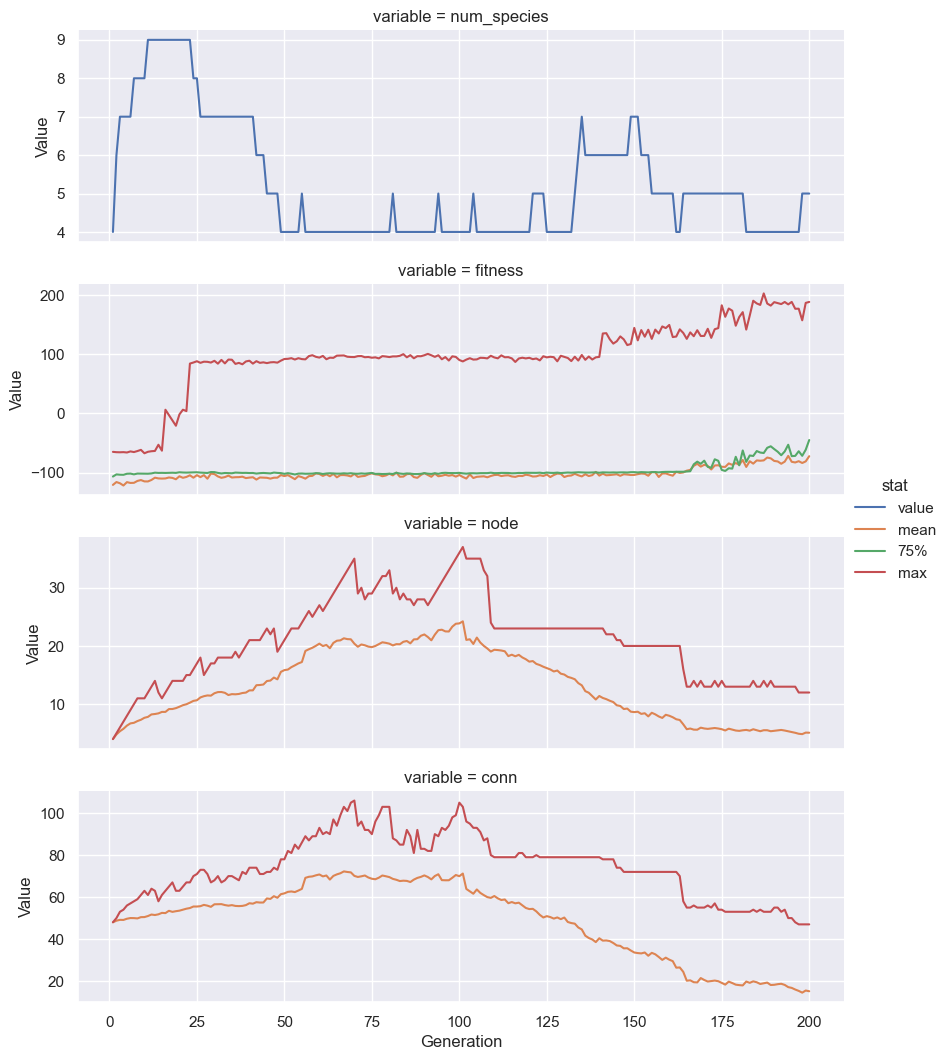

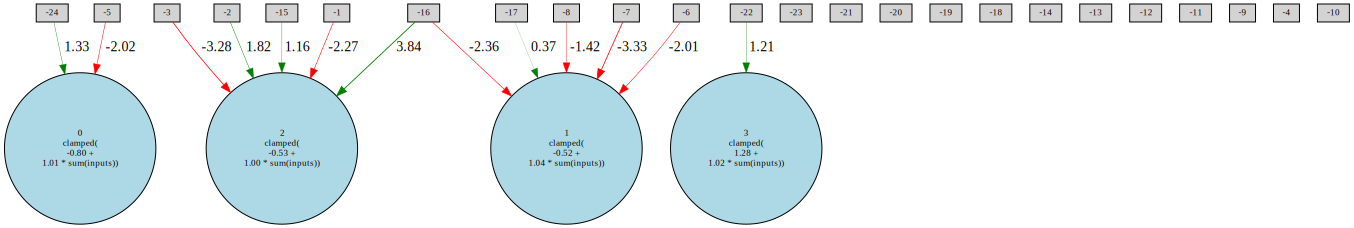

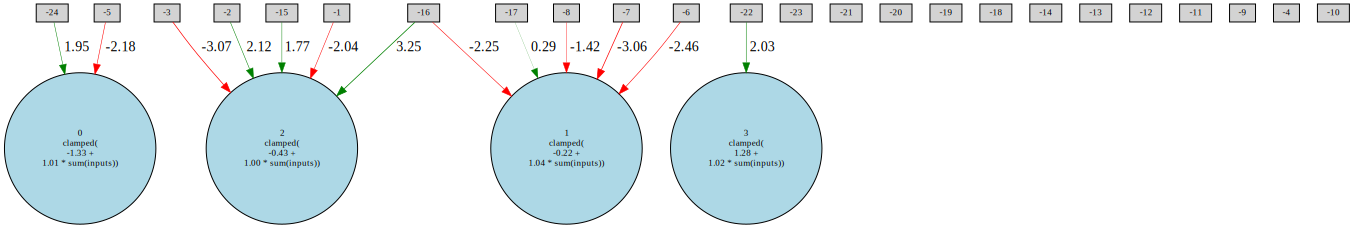

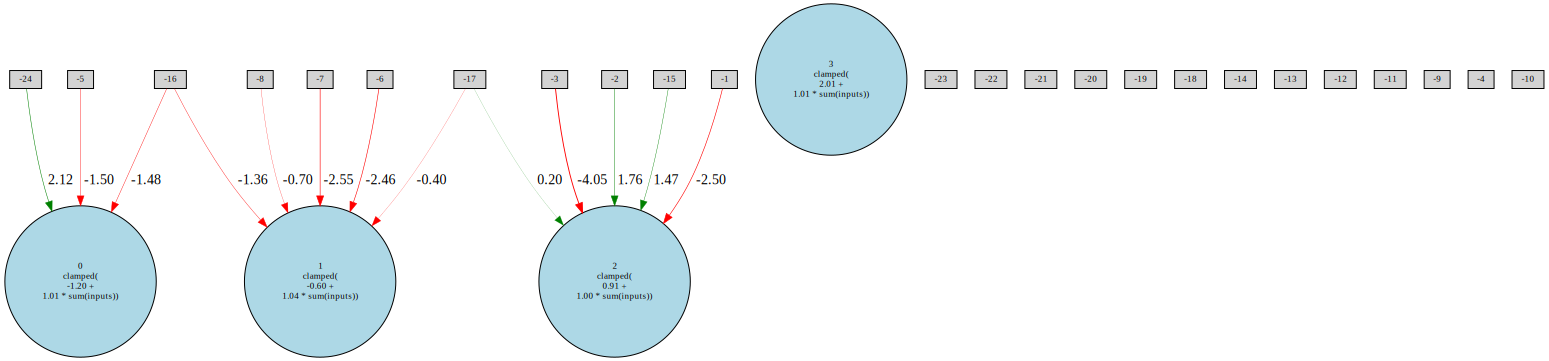

In [299]:
# expname = best_performers.index[10]
# expname = trials.index[7]
expname = "walker-grow-prune-2"
cols_to_plot = ["num_species", "fitness.mean", "fitness.75%", "fitness.max", "node.mean", "node.max", "node.top5_mean",
                "conn.mean", "conn.max", "conn.top5_mean", "best_genome_num_nodes", "best_genome_num_conns"]
plot_experiment(experiments, expname, cols_to_plot)
display(SVG("experiments/" + expname + "/winner-0-net-pruned.gv.svg"))
display(SVG("experiments/" + expname + "/winner-1-net-pruned.gv.svg"))
display(SVG("experiments/" + expname + "/winner-2-net-pruned.gv.svg"))

In [224]:
# Group results by experiment; only experiments with at least 3 trials.
from scipy.stats import mannwhitneyu

expcol = best_performers.index.get_level_values("experiment")
namewidth = max(len(n) for n in expcol)
baseline_trials = best_performers.loc[expcol.str.fullmatch("walker-baseline(-[0-9])?$")]
grow_prune_trials = best_performers.loc[expcol.str.fullmatch("walker-grow-prune(-[0-9])?$")]

# Find each unique string that is followed by nothing or by a single digit indicating trial number.
all_trials = {}
for n, g in expcol.str.extract("(.+?)(-[0-9])?$").groupby(0):
    if len(g) >= 3:
        trials = best_performers.loc[expcol.str.fullmatch(n + "(-[0-9])?$")]
        all_trials[n] = trials

for n, trials in sorted(all_trials.items(), key=lambda e: e[1].mean(), reverse=True):
    # pval = mannwhitneyu(trials, baseline_trials, alternative="greater").pvalue
    pval = mannwhitneyu(trials, grow_prune_trials, alternative="less").pvalue
    print(f"{n:{namewidth}} {trials.mean():5.1f} ({trials.std():5.1f} std) ({pval:3.2f} p-value)")

walker-high-struct-mutation-c90n30                  274.3 ( 25.0 std) (0.95 p-value)
walker-high-structural-mutation                     262.4 ( 24.6 std) (0.95 p-value)
walker-grow-only-c90n30                             256.8 ( 17.9 std) (0.90 p-value)
walker-high-struct-mutation-always-single           256.8 (  8.5 std) (0.90 p-value)
walker-high-struct-mutation-always                  252.1 ( 27.6 std) (0.90 p-value)
walker-init0.1-grow-prune                           250.8 ( 42.5 std) (0.80 p-value)
walker-grow50-prune150                              250.6 ( 41.0 std) (0.95 p-value)
walker-grow-always-c90n30                           244.1 ( 34.3 std) (0.90 p-value)
walker-baseline                                     239.6 ( 21.8 std) (0.89 p-value)
walker-grow-always-single                           233.7 ( 28.1 std) (0.90 p-value)
walker-grow-only                                    232.6 ( 28.8 std) (0.50 p-value)
walker-grow-only-single                             230.3 ( 19.1 

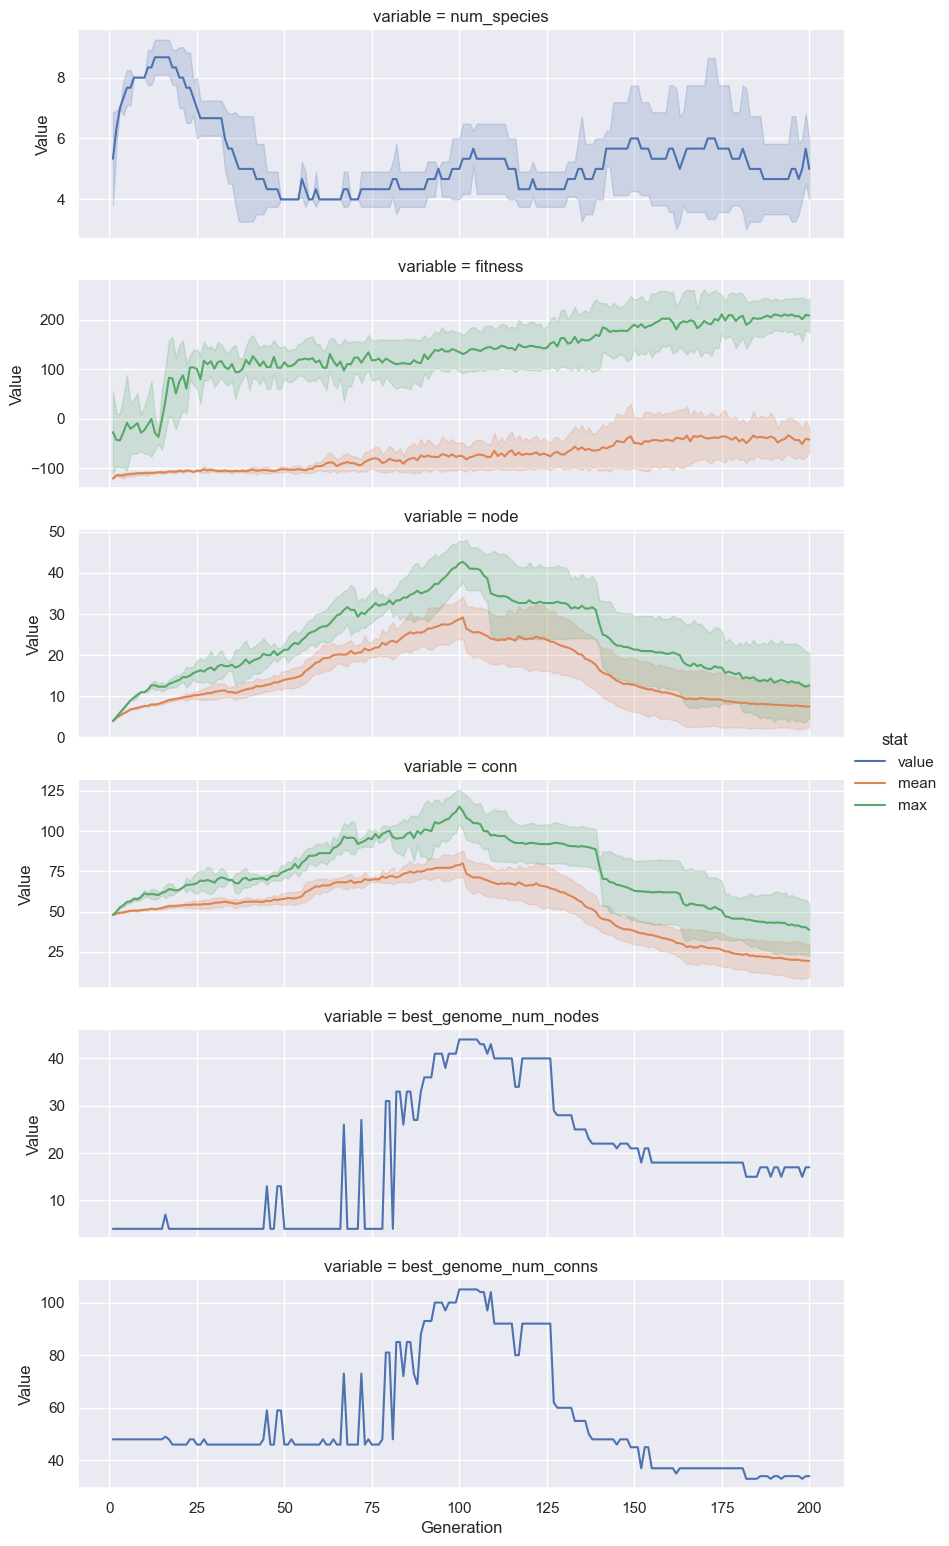

In [313]:
expname = "walker-grow-prune"
cols_to_plot = ["num_species", "fitness.mean", "fitness.max", "node.mean", "node.max",
                "conn.mean", "conn.max", "best_genome_num_nodes", "best_genome_num_conns"]
plot_trials(experiments, expname, cols_to_plot, True)

In [77]:
target = "walker-init0.1-grow-always.*"
expcol = experiments.index.get_level_values("experiment")
filtered = experiments.loc[expcol.str.match(target)]
cols = filtered.columns[filtered.columns.str.contains("_rate")]
colwidth = max(len(c) for c in cols) + 1
for metric in cols:
    print(f"{metric:{colwidth}}= {filtered[metric].mean():5.1%} (std {filtered[metric].std() * 100:5.2f})")

node_add_success_rate    =  3.6% (std  3.15)
node_add_failure_rate    = 90.8% (std  4.53)
node_remove_success_rate =  3.3% (std  9.23)
node_remove_failure_rate = 90.6% (std 16.15)
conn_add_success_rate    =  3.7% (std  2.50)
conn_add_failure_rate    = 90.4% (std  3.77)
conn_remove_success_rate =  4.1% (std  8.52)
conn_remove_failure_rate = 90.1% (std 11.73)
weight_only_success_rate =  4.2% (std  6.32)
weight_only_failure_rate = 89.6% (std  9.26)


# Scratch Area

In [10]:
experiments

num_species  \
experiment                                 generation                
walker-grow150-prune50                     1                     5   
                                           2                     5   
                                           3                     5   
                                           4                     5   
                                           5                     5   
...                                                            ...   
walker-init0.1-high-struct-mutation-c90n30 196                   5   
                                           197                   5   
                                           198                   5   
                                           199                   5   
                                           200                   5   

                                                       best_genome  \
experiment                                 generation                
walker-grow150-prune50                     1                    10   
                                           2                   159   
                                           3                   374   
                                           4                   374   
                                           5                   667   
...                                                            ...   
walker-init0.1-high-struct-mutation-c90n30 196               24024   
                                           197               24024   
                                           198               24024   
                                           199               24024   
                                           200               24024   

                                                       conn_add_prob  \
experiment                                 generation                  
walker-grow150-prune50                     1                     0.9   
                                           2                     0.9   
                                           3                     0.9   
                                           4                     0.9   
                                           5                     0.9   
...                                                              ...   
walker-init0.1-high-struct-mutation-c90n30 196                   0.1   
                                           197                   0.1   
                                           198                   0.1   
                                           199                   0.1   
                                           200                   0.1   

                                                       conn_delete_prob  \
experiment                                 generation                     
walker-grow150-prune50                     1                        0.1   
                                           2                        0.1   
                                           3                        0.1   
                                           4                        0.1   
                                           5                        0.1   
...                                                                 ...   
walker-init0.1-high-struct-mutation-c90n30 196                      0.1   
                                           197                      0.1   
                                           198                      0.1   
                                           199                      0.1   
                                           200                      0.1   

                                                       node_add_prob  \
experiment                                 generation                  
walker-grow150-prune50                     1                     0.9   
                                           2                     0.9   
                                

In [170]:
# Listing which experiments have new metrics values.
frozenset(experiments.loc[experiments["pop_size"] > 0].index.get_level_values("experiment"))

frozenset({'walker-baseline',
           'walker-baseline-1',
           'walker-baseline-2',
           'walker-baseline-3',
           'walker-grow-always-1',
           'walker-grow-always-c90n30-1',
           'walker-grow-always-c90n30-2',
           'walker-grow-always-single-1',
           'walker-grow-always-single-2',
           'walker-grow-only-1',
           'walker-grow-only-c90n30-1',
           'walker-grow-only-c90n30-2',
           'walker-grow-only-single-1',
           'walker-grow-only-single-2',
           'walker-grow-only-spec1.5',
           'walker-grow-prune-1',
           'walker-grow-prune-c90n30-1',
           'walker-grow-prune-pop300',
           'walker-grow-prune-single-1',
           'walker-grow-prune-spec1.5',
           'walker-grow150-prune50-1',
           'walker-grow150-prune50-2',
           'walker-grow50-prune150-1',
           'walker-grow50-prune150-2',
           'walker-high-struct-mutation-always-1',
           'walker-high-struct-mutati

In [268]:
np.nansum([np.nan, np.nan])

0.0